In [ ]:
# Analysis workflow adopted & modified from https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html &
# Data collected & inspo from :https://divingintogeneticsandgenomics.com/post/neighborhood-cellular-niches-analysis-with-spatial-transcriptome-data-in-seurat-and-bioconductor/

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

In [ ]:
# Check working directory
import os
os.getcwd()

In [3]:
# Set working directory to where the files are
new_directory = "../G000428_MaiLa/20231101__013606__G000428_MaiLa_01112023_B1/output-XETG00068__0010617__Region_4__20231101__013739"
os.chdir(new_directory)

In [5]:
adata = sc.read_10x_h5("cell_feature_matrix.h5")
df = pd.read_csv("cells.csv")
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [7]:
# Subset data to region of interest
# Create a boolean mask based on spatial coordinates
x_min = 1200
x_max = 4000
y_min = 3600
y_max = 5800

criteria = (
    (adata.obs['x_centroid'] >= x_min) & (adata.obs['x_centroid'] <= x_max) &
    (adata.obs['y_centroid'] >= y_min) & (adata.obs['y_centroid'] <= y_max)
)
# Subset the AnnData object based on the spatial criteria
subset_adata = adata[criteria, :]

In [8]:
subset_adata.obs['transcript_counts'] # 27k cells

aabcbcci-1    374
aabcebli-1    205
aabcgkkb-1    335
aabcoenn-1    285
aabdjack-1    203
             ... 
mpfkiihk-1      9
mpfkmalo-1     43
mpflahjl-1    135
mpfmkphb-1    100
mpfnbhid-1     63
Name: transcript_counts, Length: 27148, dtype: int64

In [9]:
# CALCULATING QC METRICS
sc.pp.calculate_qc_metrics(subset_adata, percent_top=(10, 20, 50, 150), inplace=True)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [10]:
cprobes = (
   subset_adata.obs["control_probe_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
cwords = (
    subset_adata.obs["control_codeword_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0016305765718758153
Negative decoding count % : 0.0015188932450350059


/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

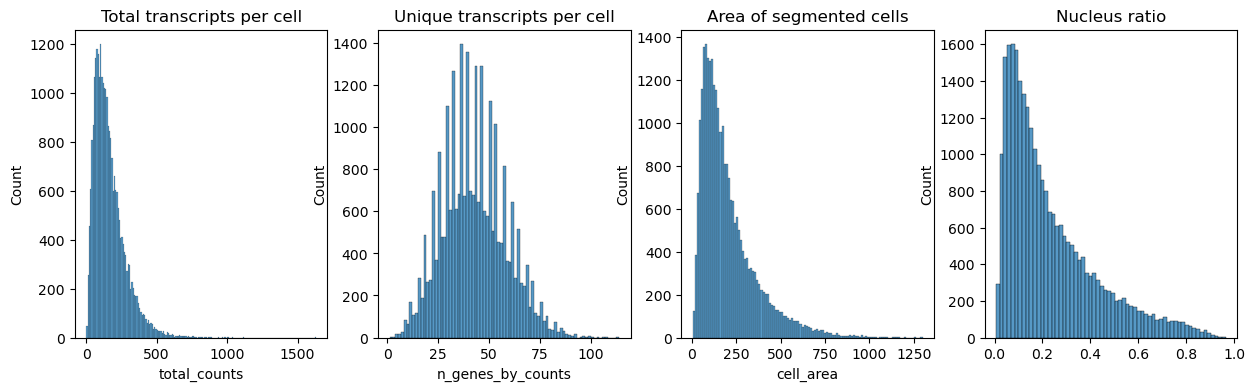

In [11]:
# Plotting QC metrics - again, also provided on the analysis_summary.html
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    subset_adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    subset_adata.obs["nucleus_area"] / subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 700.0)

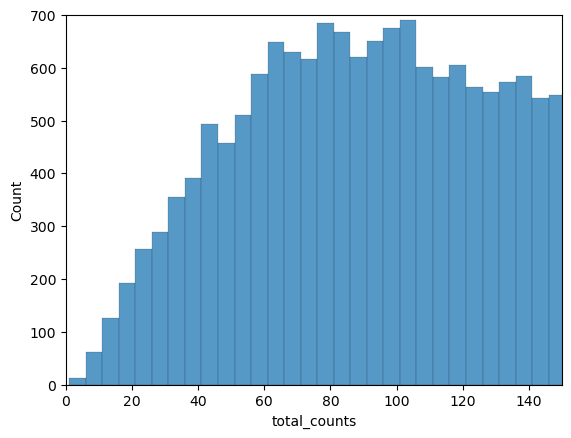

In [13]:
#fig, axs = plt.subplots(1, 4, figsize=(15, 4))

#axs[0].set_title("Total transcripts per cell")
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    binwidth=5)
    #ax=axs[0],)

plt.xlim(0,150)
plt.ylim(0, 700)

In [14]:
# Filtering cells/genes based on QC graph above. Filter criteria can be cell area, DAPI signal or minium of unique transcripts
sc.pp.filter_cells(subset_adata, min_counts=15) # The Xenium anlysis summary would help
sc.pp.filter_genes(subset_adata, min_cells=5) #min number of cells expresed required for a gene to pass filtering; min # of counts required for a gene to pass filtering. Using Xenium explorer to help

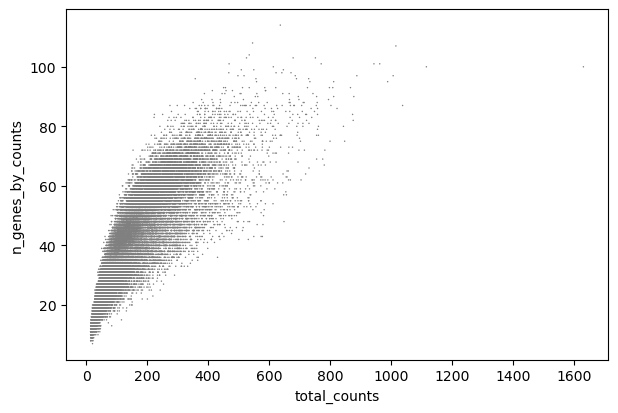

In [16]:
# Following scanpy preprocessing workflow https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
sc.pl.scatter(subset_adata, x='total_counts', y='n_genes_by_counts') # check whether to remove more

In [17]:
# Normalisation using default setting
subset_adata.layers["counts"] = subset_adata.X.copy()
sc.pp.normalize_total(subset_adata, inplace=True)
sc.pp.log1p(subset_adata)
subset_adata.layers['scaled'] = sc.pp.scale(subset_adata, copy=True).X
sc.pp.pca(subset_adata) 

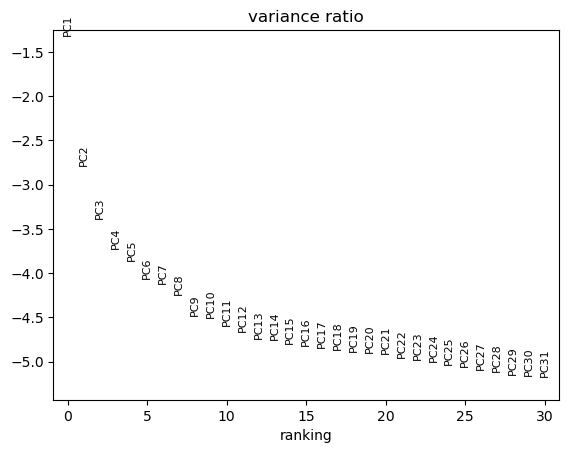

In [20]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [21]:
# can read more about setting the parameter at https://umap-learn.readthedocs.io/en/latest/parameters.html
sc.pp.neighbors(subset_adata,
               n_neighbors =15) # n_neighbour default = 15, can set between 2-200, controls how UMAP balances local vs global structure in the data; small n-neigbours = focus more on local structure, 

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
sc.tl.umap(subset_adata)

In [22]:
# Clustering by leiden, using different resolutions
resolutions = [1.8, 4.0]

for resolution in resolutions:
    key_added = f"leiden_{resolution}"
    sc.tl.leiden(subset_adata, resolution=resolution, key_added=key_added)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype 

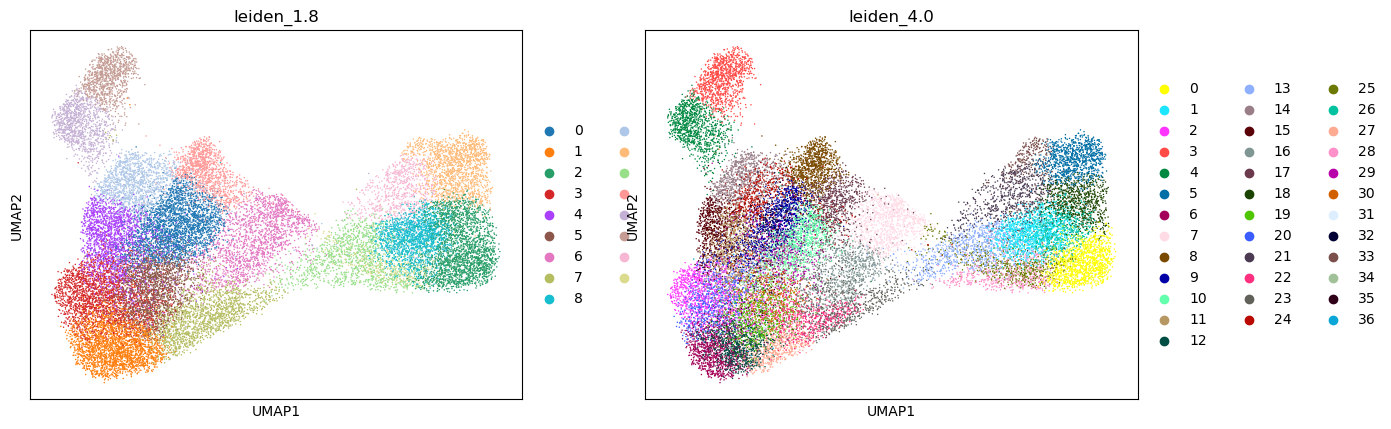

In [26]:
sc.pl.umap(subset_adata, color=['leiden_1.8','leiden_4.0']) # leiden 4.0 is used to capture Tuft cells

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

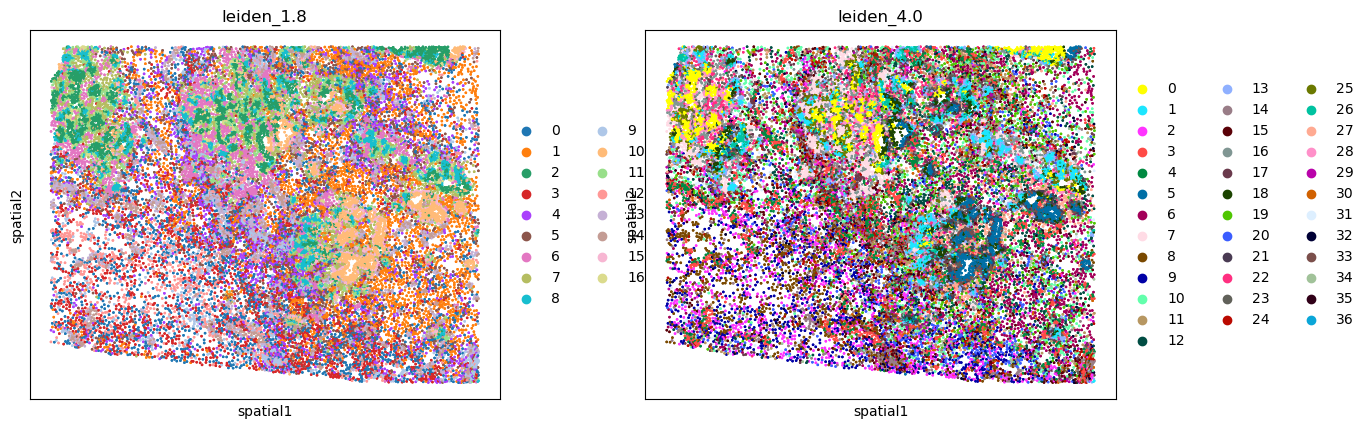

In [27]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    shape=None,
    color=["leiden_1.8", "leiden_4.0"],
    size = 3
)

In [ ]:
# Find Marker genes
# by ranking highly differentially expressed genes in each cluster
sc.tl.rank_genes_groups(subset_adata, 'leiden_4.0', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=25, sharey=False)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype 

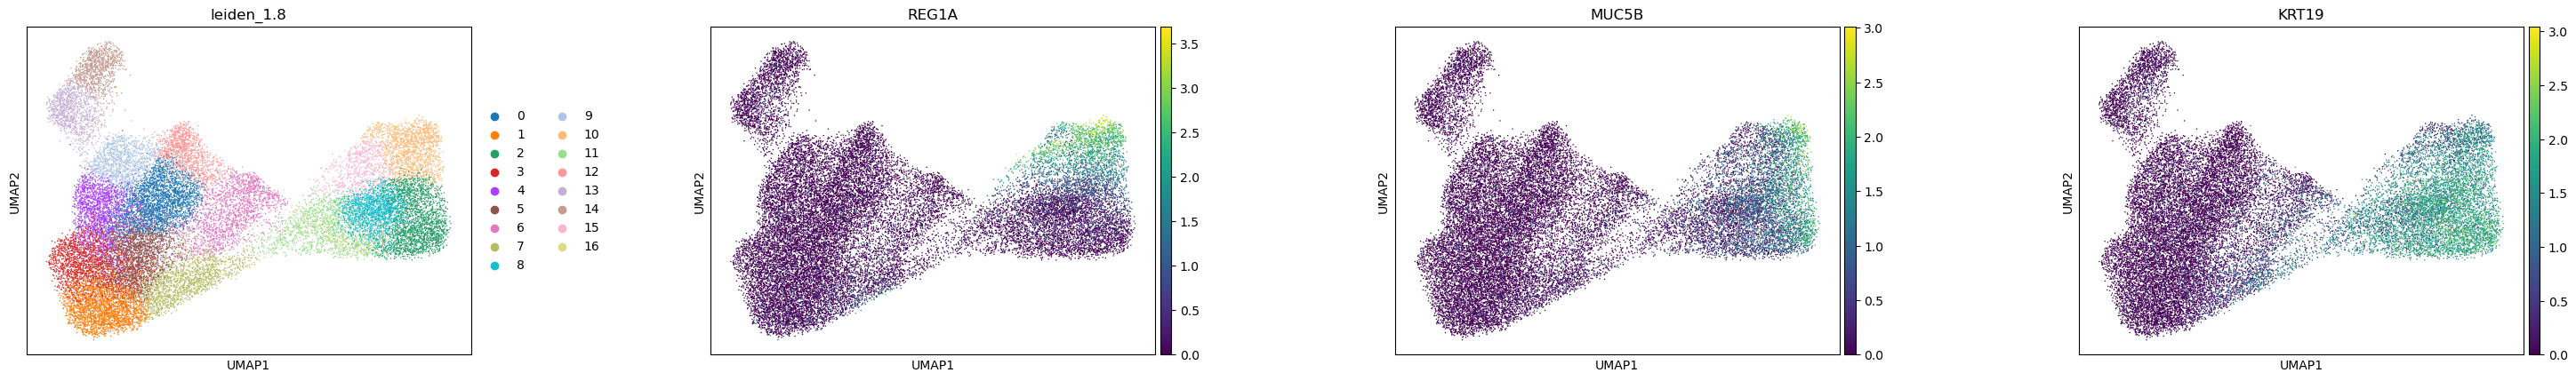

In [70]:
sc.pl.umap(subset_adata, color=['leiden_1.8','REG1A','MUC5B','KRT19'], wspace = 0.4) 

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype 

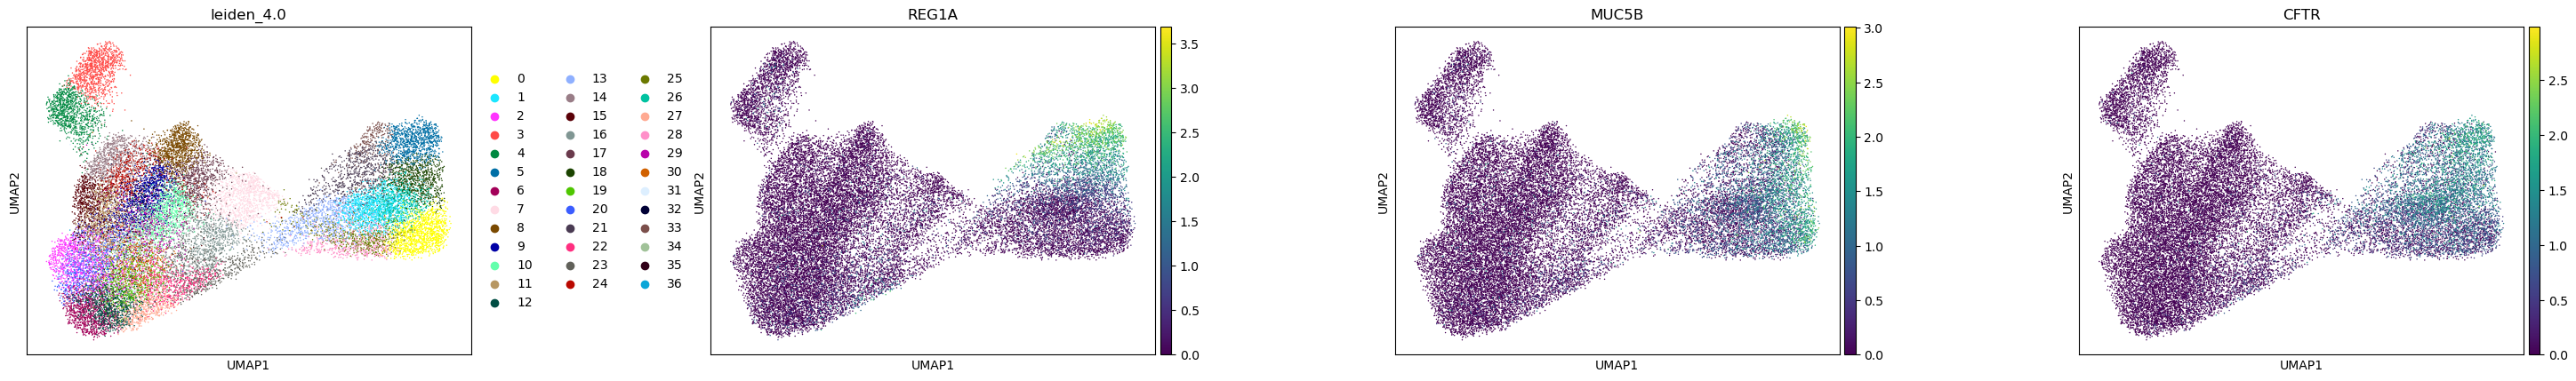

In [63]:
sc.pl.umap(subset_adata, color=['leiden_4.0','REG1A','MUC5B','CFTR'], wspace = 0.4) 

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


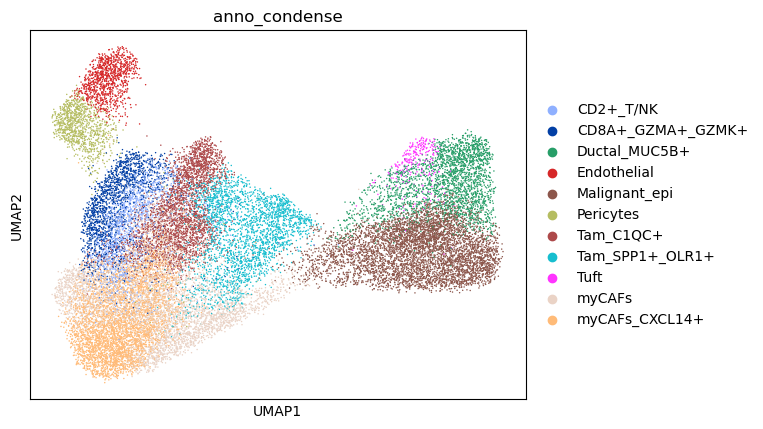

In [64]:
sc.pl.umap(subset_adata, color=["anno_condense"], wspace = 0.4)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


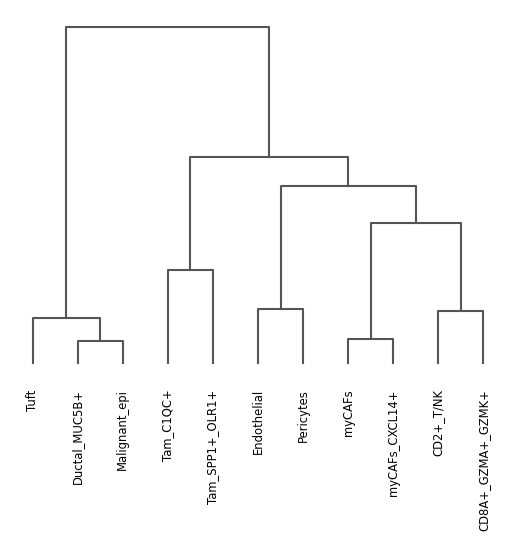

<Axes: >

In [123]:
# Running dendogram
sc.tl.dendrogram(subset_adata, groupby = "anno_condense")
sc.pl.dendrogram(subset_adata, groupby = "anno_condense")

In [118]:
# CLUSTER ANNOATION  - CURRENT
cluster_anno_condense = {
    "0": "Malignant_epi",
    "1": "Malignant_epi",
    "2": "myCAFs",#CAFs_MYO
    "3": "Endothelial",
    "4": "Pericytes",
    "5": "Ductal_MUC5B+", #also express lowly express REG1A but no REG3A+
    "6": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "7": "Tam_SPP1+_OLR1+",
    "8": "Tam_C1QC+",
    "9": "Tam_C1QC+",
    "10": "Tam_C1QC+",
    "11": "CD2+_T/NK",
    "12": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "13": "Malignant_epi",
    "14": "CD8A+_GZMA+_GZMK+", # with effector function, express Nk/TRM markers and PRF1, 
    "15": "CD8A+_GZMA+_GZMK+",
    "16": "Tam_SPP1+_OLR1+",
    "17": "Tam_SPP1+_OLR1+",
    "18": "Ductal_MUC5B+",
    "19": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "20": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "21": "Malignant_epi", 
    "22": "myCAFs",
    "23": "myCAFs",
    "24": "CD2+_T/NK",
    "25": "Malignant_epi",
    "26": "Malignant_epi",
    "27": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "28": "Malignant_epi",
    "29": "myCAFs",
    "30": "myCAFs",
    "31": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "32": "myCAFs",
    "33": "Tuft",
    "34": "myCAFs_CXCL14+",#CAFs_MYO_CXCL14+
    "35": "myCAFs_CXCL14+", #CAFs_MYO_CXCL14+
    "36": "myCAFs" #CAFs_MYO
}

In [119]:
subset_adata.obs["anno_condense"] = subset_adata.obs['leiden_4.0'].map(cluster_anno_condense)
subset_adata.obs['leiden_4.0'].map(cluster_anno_condense)

aabcbcci-1        Malignant_epi
aabcebli-1        Malignant_epi
aabcgkkb-1               myCAFs
aabcoenn-1        Malignant_epi
aabdjack-1        Malignant_epi
                    ...        
mpfjmgph-1       myCAFs_CXCL14+
mpfkmalo-1       myCAFs_CXCL14+
mpflahjl-1            Tam_C1QC+
mpfmkphb-1    CD8A+_GZMA+_GZMK+
mpfnbhid-1    CD8A+_GZMA+_GZMK+
Name: leiden_4.0, Length: 26974, dtype: object

In [145]:
genes = ['RGS13','AVIL','BMX',
         'REG1A','MUC5B','CFTR',
         'KRT8','KRT19','KRT7','FXYD3','MUC1',
         'CD163','SELENOP','C1QA','HLA-DMB','MERTK',
         'APOE','SPP1','MARCO','OLR1','APOC1','GRN',
          'VWF','DLL4',
         'PDGFRB','RGS5','CSPG4','GJC1', 
         'PDGFC',
         'POSTN','ACTA2','CALD1','COL11A1','CXCL14','IGFBP3',
          'CD2','IL7R','CD3E','CD3G',
         'CD8A','GZMA','GZMK'
        ]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


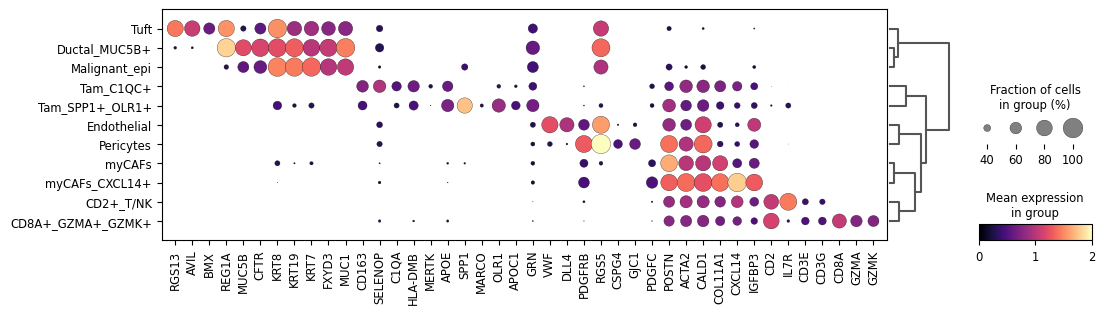

In [147]:
sc.pl.dotplot(subset_adata, var_names = genes , groupby='anno_condense', #swap_axes = True, 
              figsize=(12, 3), vmax=2, dot_min=0.2, cmap = 'magma',
             dendrogram=True, 
             save = 'Fig4.pdf'
             )

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


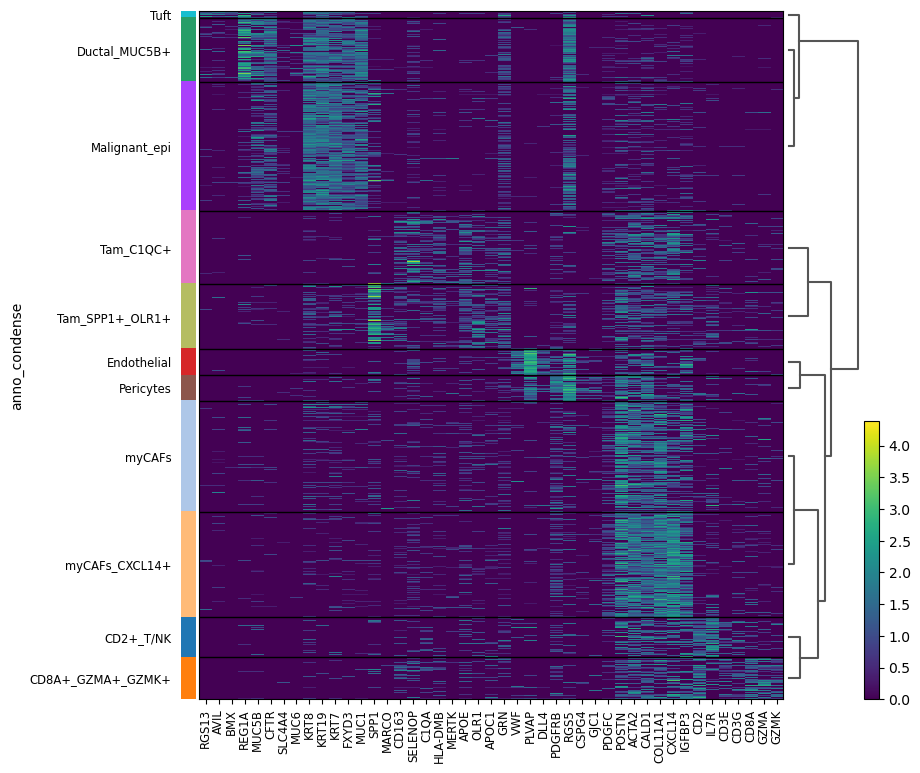

In [89]:
sc.pl.heatmap(subset_adata, genes, groupby='anno_condense', cmap='viridis', dendrogram=True, figsize=(9, 9), show_gene_labels=True)

In [4]:
imm = ['PVR','NECTIN1','NECTIN2','NECTIN3','NECTIN4','TIGIT',
       'CD226','CD274','PDCD1LG2','PDCD1','CD80','CD28',
       'CTLA4','LAG3',
      'LGALS9','HAVCR2','CD86','VSIR','ITGAE']

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


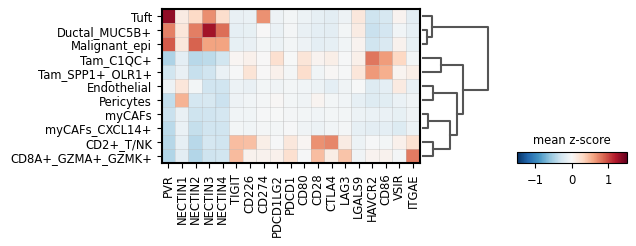

In [6]:
sc.pl.matrixplot(subset_adata, imm, groupby='anno_condense', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1.5, vmax=1.5, cmap='RdBu_r',  
                 figsize=(6, 2), #save='immunecheckpoint_v2.pdf'
                )

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

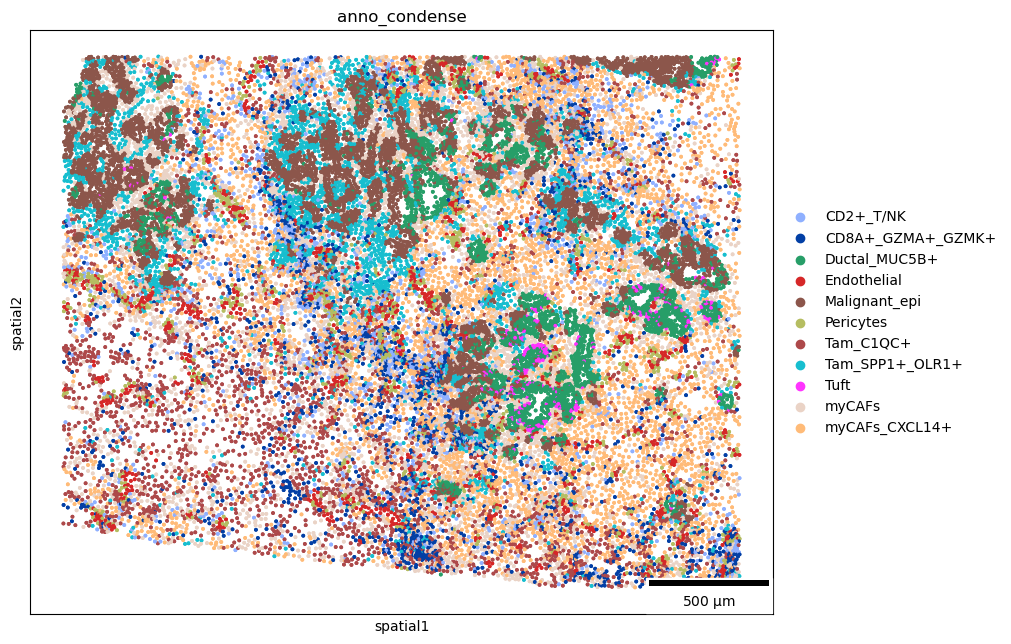

In [64]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    shape=None,
    size=12,
    color=[
        "anno_condense",
        #"anno"
    ],
    wspace=0.4,
    figsize = (10,8),scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    #save = 'Fig4E.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


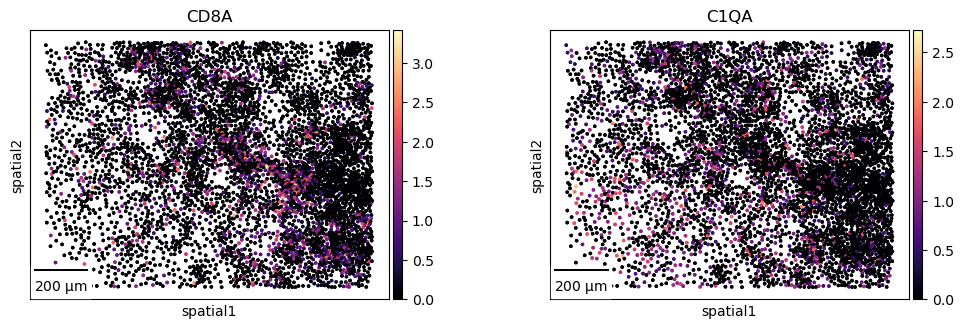

In [16]:
# Plotting a crop region
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "CD8A", "C1QA"
    ],
    shape=None,
    crop_coord=[(1800, 4400, 3000, 5300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10,
    img=False,
    wspace=0.2, cmap="magma",
    figsize = (5,3.5), save=
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


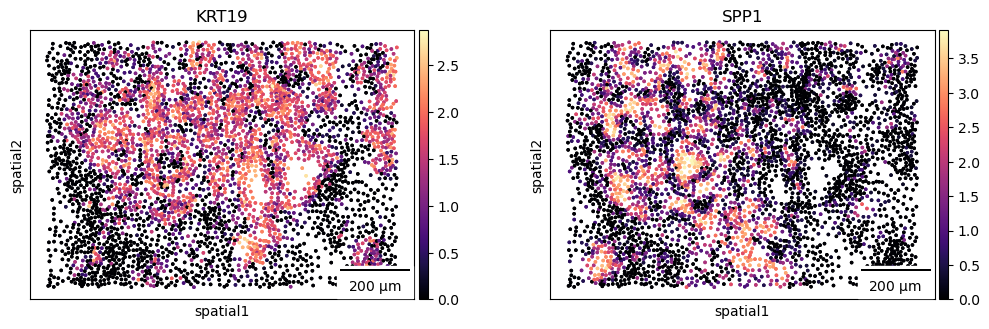

In [11]:
# Plotting a crop region
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "KRT19","SPP1"
    ],
    shape=None,
    crop_coord=[(2000, 3800, 3000, 4500)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    size=10,
    img=False,
    wspace=0.2, cmap="magma",
    figsize = (5,3.5),#, 
    save= 'SFig4_cropped_1.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


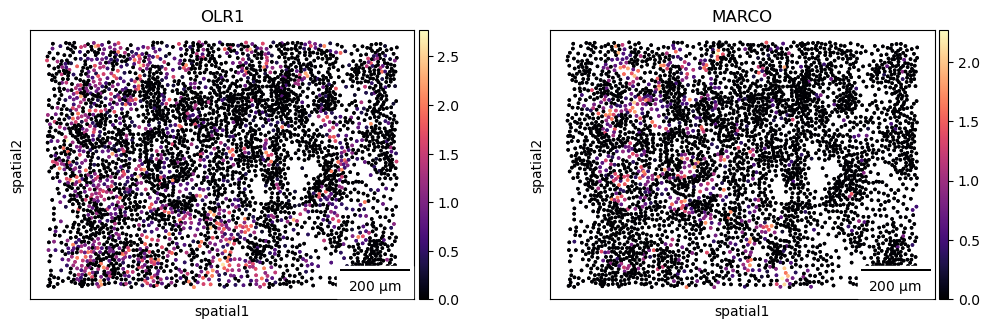

In [12]:
# Plotting a crop region
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "OLR1","MARCO"
    ],
    shape=None,
    crop_coord=[(2000, 3800, 3000, 4500)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    size=10,
    img=False,
    wspace=0.2, cmap="magma",
    figsize = (5,3.5), save= 'SFig4_cropped_2.pdf'
)

In [67]:
cluster_counts = subset_adata.obs['anno_condense'].value_counts()
cluster_proportions = cluster_counts / len(subset_adata.obs)
print(cluster_proportions)

anno_condense
Malignant_epi        0.188478
myCAFs               0.160822
myCAFs_CXCL14+       0.153444
Tam_C1QC+            0.105880
Tam_SPP1+_OLR1+      0.093942
Ductal_MUC5B+        0.092163
CD8A+_GZMA+_GZMK+    0.061318
CD2+_T/NK            0.057982
Endothelial          0.038704
Pericytes            0.037184
Tuft                 0.010084
Name: count, dtype: float64


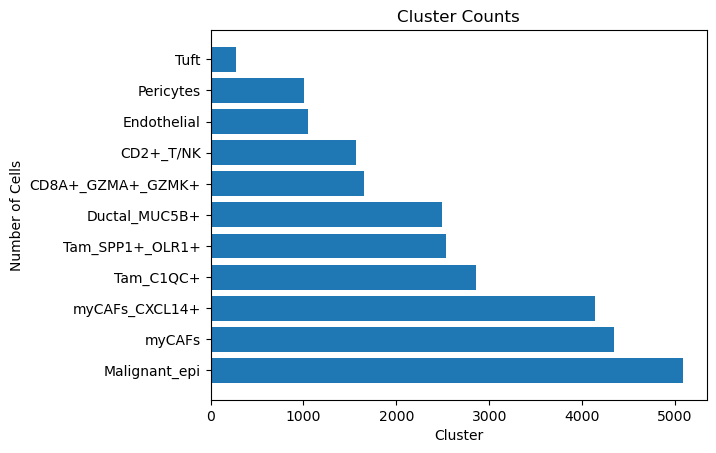

In [68]:
# Plot bar plot
#plt.bar(cluster_counts.index, cluster_counts.values)
plt.barh(cluster_counts.index, cluster_counts.values) # to swap axis
plt.xlabel('Cluster')
plt.ylabel('Number of Cells')
plt.title('Cluster Counts')
plt.show()

In [69]:
# stacked barplot
cluster_counts = subset_adata.obs["anno_condense"].value_counts()
cluster_proportions = cluster_counts / len(subset_adata.obs)
#print(cluster_proportions_dense)
df = pd.DataFrame(cluster_counts / len(subset_adata.obs))
df.columns = ['count'] # change columne name
df

count
anno_condense              
Malignant_epi      0.188478
myCAFs             0.160822
myCAFs_CXCL14+     0.153444
Tam_C1QC+          0.105880
Tam_SPP1+_OLR1+    0.093942
Ductal_MUC5B+      0.092163
CD8A+_GZMA+_GZMK+  0.061318
CD2+_T/NK          0.057982
Endothelial        0.038704
Pericytes          0.037184
Tuft               0.010084

In [70]:
df_transposed = df.transpose()

In [73]:
df_transposed.columns=pd.CategoricalIndex(df_transposed.columns.values, ordered=True, categories=['CD2+_T/NK', 'CD8A+_GZMA+_GZMK+', 'Ductal_MUC5B+', 'Endothelial',
       'Malignant_epi', 'Pericytes', 'Tam_C1QC+', 'Tam_SPP1+_OLR1+', 'Tuft',
       'myCAFs', 'myCAFs_CXCL14+'])
df_transposed = df_transposed.sort_index(axis=1)

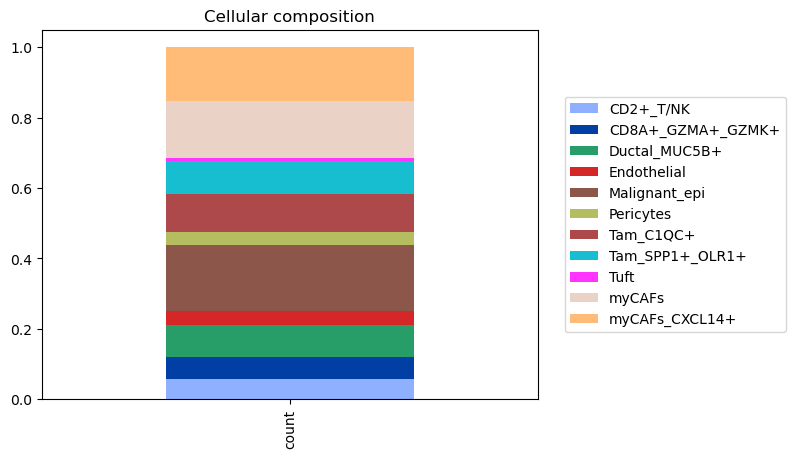

<Figure size 100x100 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [79]:
# plot data in stack manner of bar type
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot/43439132#43439132
df_transposed.plot.bar(stacked=True, title='Cellular composition', color= colors)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.figure(figsize=(1,1))
plt.show()
plt.savefig('plot.pdf')

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.41/s]
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

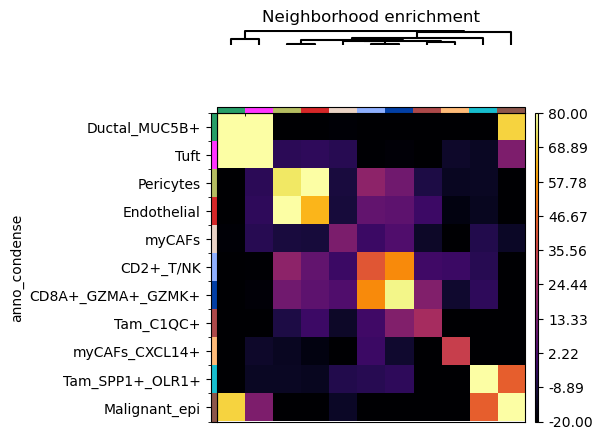

In [150]:
# Spatial analysis
# Neighbourhood enrichment analysis, clustering resolution definitely can be improved further 
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", spatial_key="spatial", radius=50) # can add radius and n_neighbour
sq.gr.nhood_enrichment(subset_adata, cluster_key="anno_condense", seed=2214)
sq.pl.nhood_enrichment(
    subset_adata,
    cluster_key="anno_condense",
    method="average",
    cmap="inferno",
    vmin=-20,
    vmax=80,
    figsize=(4, 4), save = 'Fig4D.enrichment.pdf'
)

In [88]:
sq.gr.co_occurrence(
    subset_adata,
    cluster_key="anno_condense",
    n_splits = 1,
    n_jobs = 5
) 

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.87s/]


/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

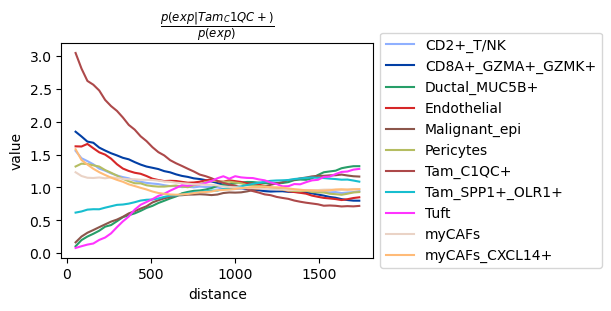

In [94]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    subset_adata,
    cluster_key= "anno_condense",
    clusters= "Tam_C1QC+", # choose the cell type to focus on
    figsize=(6, 3), save = 'Tam_c1qc.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

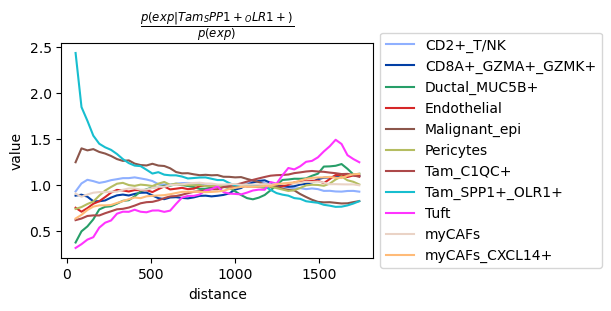

In [95]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    subset_adata,
    cluster_key= "anno_condense",
    clusters= "Tam_SPP1+_OLR1+", # choose the cell type to focus on
    figsize=(6, 3), save = 'spp1.pdf'
)

In [208]:
# Compute Moran's I score: to determine spatially variable genes
# The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    subset_adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.45/s]


In [210]:
subset_adata.uns["moranI"].head(50) # top genes that show strong spatial patterning

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
REG1A     0.776210        0.0  0.000013         0.0  0.009901  0.000031   
SERPINA1  0.738083        0.0  0.000013         0.0  0.009901  0.000028   
VEGFA     0.731324        0.0  0.000013         0.0  0.009901  0.000027   
KRT19     0.696013        0.0  0.000013         0.0  0.009901  0.000029   
TFF1      0.678143        0.0  0.000013         0.0  0.009901  0.000019   
FN1       0.668122        0.0  0.000013         0.0  0.009901  0.000019   
COL1A1    0.653016        0.0  0.000013         0.0  0.009901  0.000022   
MUC1      0.651089        0.0  0.000013         0.0  0.009901  0.000025   
COL1A2    0.647692        0.0  0.000013         0.0  0.009901  0.000024   
SPP1      0.642369        0.0  0.000013         0.0  0.009901  0.000024   
KRT8      0.628295        0.0  0.000013         0.0  0.009901  0.000030   
KRT7      0.608245        0.0  0.000013         0.0  0.009901  0.000022   
FXYD3     0.606422        0.0  0.000013         0.0  0.009901  0.000024   
MUC5B     0.602053        0.0  0.000013         0.0  0.009901  0.000015   
TCIM      0.585111        0.0  0.000013         0.0  0.009901  0.000024   
CFTR      0.581203        0.0  0.000013         0.0  0.009901  0.000022   
CXCL14    0.572394        0.0  0.000013         0.0  0.009901  0.000024   
RGS5      0.569746        0.0  0.000013         0.0  0.009901  0.000022   
IGHD      0.563466        0.0  0.000013         0.0  0.009901  0.000021   
EPCAM     0.552953        0.0  0.000013         0.0  0.009901  0.000020   
PLVAP     0.543483        0.0  0.000013         0.0  0.009901  0.000025   
CDH1      0.503943        0.0  0.000013         0.0  0.009901  0.000020   
MUC3A     0.492776        0.0  0.000013         0.0  0.009901  0.000022   
REG3A     0.490039        0.0  0.000013         0.0  0.009901  0.000019   
FLT1      0.487091        0.0  0.000013         0.0  0.009901  0.000018   
IGHG1     0.486721        0.0  0.000013         0.0  0.009901  0.000018   
RGS13     0.483209        0.0  0.000013         0.0  0.009901  0.000024   
TMPRSS4   0.478084        0.0  0.000013         0.0  0.009901  0.000018   
TMC5      0.470316        0.0  0.000013         0.0  0.009901  0.000022   
HLA-B     0.453341        0.0  0.000013         0.0  0.009901  0.000020   
CAPN8     0.450553        0.0  0.000013         0.0  0.009901  0.000017   
CXCL3     0.442923        0.0  0.000013         0.0  0.009901  0.000017   
CD47      0.438431        0.0  0.000013         0.0  0.009901  0.000014   
IGFBP3    0.435622        0.0  0.000013         0.0  0.009901  0.000017   
THBS1     0.420513        0.0  0.000013         0.0  0.009901  0.000016   
CD74      0.416855        0.0  0.000013         0.0  0.009901  0.000013   
POSTN     0.414258        0.0  0.000013         0.0  0.009901  0.000017   
COL11A1   0.414147        0.0  0.000013         0.0  0.009901  0.000015   
CCL18     0.413210        0.0  0.000013         0.0  0.009901  0.000017   
MMP2      0.399457        0.0  0.000013         0.0  0.009901  0.000018   
MUC6      0.383080        0.0  0.000013         0.0  0.009901  0.000017   
ACTA2     0.382831        0.0  0.000013         0.0  0.009901  0.000011   
HLA-E     0.377468        0.0  0.000013         0.0  0.009901  0.000015   
ONECUT2   0.371199        0.0  0.000013         0.0  0.009901  0.000016   
PRSS1     0.368528        0.0  0.000013         0.0  0.009901  0.000013   
COL6A3    0.367835        0.0  0.000013         0.0  0.009901  0.000016   
VWF       0.367048        0.0  0.000013         0.0  0.009901  0.000015   
SUCNR1    0.357682        0.0  0.000013         0.0  0.009901  0.000014   
SELENOP   0.348546        0.0  0.000013         0.0  0.009901  0.000017   
REG4      0.341873        0.0  0.000013         0.0  0.009901  0.000016   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
REG1A                  0.0                0.0          0.01072  
SERPINA1               0.0                0.0          0.0107

In [6]:
import pandas as pd
counts_matrix = subset_adata.X.toarray() 

# Create a DataFrame with the counts for all genes across all cells
df_all_counts = pd.DataFrame(
    counts_matrix,
    index=subset_adata.obs_names,      # Cell barcodes as row index
    columns=subset_adata.var.index     # Gene symbols as column headers
)

df_all_counts['cell_class'] = subset_adata.obs['anno_condense'].values
df_all_counts['Lv.2.Anno'] = subset_adata.obs['anno_extended'].values
df_all_counts['transcript_counts'] = subset_adata.obs['transcript_counts'].values
df_all_counts['x_location'] = subset_adata.obs['x_centroid'].values
df_all_counts['y_location'] = subset_adata.obs['y_centroid'].values

In [7]:
# List the last four columns that you want to move to the front
columns_to_move = ['x_location', 'y_location', 'cell_class', 'Lv.2.Anno','transcript_counts']

new_column_order = columns_to_move + [col for col in df_all_counts.columns if col not in columns_to_move]

df_all_counts = df_all_counts[new_column_order]

print(df_all_counts)

             x_location   y_location         cell_class          Lv.2.Anno  \
aabcbcci-1  2475.888916  3827.184814      Malignant_epi      Malignant_epi   
aabcebli-1  2472.579346  3839.016846      Malignant_epi      Malignant_epi   
aabcgkkb-1  2493.578369  3840.627930             myCAFs           CAFs_MYO   
aabcoenn-1  2467.979248  3847.445801      Malignant_epi      Malignant_epi   
aabdjack-1  2463.701660  3830.395508      Malignant_epi      Malignant_epi   
...                 ...          ...                ...                ...   
mpfjmgph-1  2562.232422  5197.326660     myCAFs_CXCL14+   CAFs_MYO_CXCL14+   
mpfkmalo-1  2552.589844  5205.840820     myCAFs_CXCL14+   CAFs_MYO_CXCL14+   
mpflahjl-1  2511.119629  5203.662598          Tam_C1QC+         TAMs_C1QC+   
mpfmkphb-1  2538.710205  5208.362305  CD8A+_GZMA+_GZMK+  CD8A+_GZMA+_GZMK+   
mpfnbhid-1  2567.723389  5207.411133  CD8A+_GZMA+_GZMK+  CD8A+_GZMA+_GZMK+   

            transcript_counts    ABCA10     ABCA6  ACKR1     AC

In [8]:
df_all_counts.to_csv("/homevol/huemail/G000428_MaiLa/PDAC_submission_ROI_codes_copy/counts/PDAC_Xenium_0010617_region4_P074_Fig4.csv", index=False)